### This is a notebook which tested the accuracy of a network built solely of Fully Connected layers. Then the FGSM was tested

### Imports

In [1]:
from __future__ import print_function
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import h5py
from pathlib import Path


from art.attacks import CarliniL2Method, CarliniLInfMethod
from art.classifiers import PyTorchClassifier
from art.utils import load_mnist

%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Dataset

In [2]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=64)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)

### FC Classifier

In [86]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 10)

        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x 
    

def train_classifier(cl, opt, x, y):
    x.to(device)
    y.to(device)
    #Reset gradients
    opt.zero_grad()
    #Train on real data
    pred = cl(x)
    pred.to(device)
    err = F.nll_loss(F.log_softmax(pred, dim=0), y)
    err.backward()
    #Update optimizer
    opt.step()
    return err, pred

def test_model(cl,test_loader): 
    correct = 0
    with torch.no_grad():
        cl.eval()
        for data, target in test_loader:
            data = data.reshape(-1, 28*28)
            output = cl(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            target = np.argmax(target, axis=1)
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_loader.dataset))
        
    return acc_test

### Training

In [87]:
num_epochs = 7
e_losses = [] 

# Load pre-trained model
cl = Classifier().to(device)

# optimizer
cl_opt = optim.Adam(cl.parameters(), lr=0.001, weight_decay=0)
criterion = nn.CrossEntropyLoss()

for e in range(num_epochs):
    cl.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        target = np.argmax(target, axis=1)  # transform from one-hot to int
        data = data.reshape(-1, 28*28)      # reshape
        c_error,c_pred = train_classifier(cl,cl_opt, data.to(device), target.to(device))
        e_losses.append(c_error.cpu().data.numpy())
    acc = test_model(cl,test_dataloader)
    print("Epoch ", e, ": Test accuracy: ", 100*acc, "%")

print("Performance in the trained model: ")
acc_test = test_model(cl,test_dataloader)
print("Test accuracy: ", 100*acc_test, "%")
print("FINISHED!!!")

Epoch  0 : Test accuracy:  95.7 %
Epoch  1 : Test accuracy:  97.00999999999999 %
Epoch  2 : Test accuracy:  97.45 %
Epoch  3 : Test accuracy:  97.63 %
Epoch  4 : Test accuracy:  97.77 %
Epoch  5 : Test accuracy:  97.94 %
Epoch  6 : Test accuracy:  97.8 %
Performance in the trained model: 
Test accuracy:  97.8 %
FINISHED!!!


In [48]:
torch.save(cl.state_dict(), 
           '../saved_models/Carlini/vanilla/FC_model_03.pth')

### Create ART classifier

In [88]:
# Create ART classifier with the TRAINED model
classifier = PyTorchClassifier(
    model=cl,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=nn.CrossEntropyLoss(),
    optimizer=cl_opt,
    input_shape=(-1, 28*28),
    nb_classes=10,
)

In [89]:
# Should yield the same accuracy as the one printed above
x_test = x_test.reshape(-1, 28*28)  # VIP
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

Accuracy on benign test examples: 97.8 %


## Carlini

In [84]:
# Generate adversarial test examples
def CarliniL2(classifier, x_test, init_const):
    attack = CarliniL2Method(classifier=classifier,
                            confidence=0.0,
                            targeted=False,
                            learning_rate=0.01,
                            binary_search_steps=2,
                            initial_const=init_const,
                            batch_size=64)
    x_test_adv = attack.generate(x=x_test)

    return x_test_adv

def CarliniLInf(classifier, x_test, epsilon):
    attack = CarliniLInfMethod(classifier=classifier, 
                              confidence=0.0,
                              targeted=False, 
                              learning_rate=0.01,
                              eps=epsilon, 
                              batch_size=128)
    x_test_adv = attack.generate(x=x_test)
    
    return x_test_adv

# Calculate distance 
def L2distance(x_test, x_test_adv):
    dist = 0
    samples_changed = 0
    for test, adv_test in zip(x_test, x_test_adv):
        l2 = np.linalg.norm(test-adv_test)
        dist += l2
        samples_changed = samples_changed + 1 if l2>0 else samples_changed
    dist /= samples_changed
    return dist

### L2

In [52]:
carlini_l2 = dict()
constants = [0.1, 0.5, 1.0, 5, 10]
n = 1000
accuracies = []
distances = []
# x_test must be reshaped before
for init in constants:
    x_test_adv = CarliniL2(classifier, x_test[:n], init_const=init)
    predictions = classifier.predict(x_test_adv)
    acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
    accuracies.append(round(acc, 3))
    dist = L2distance(x_test[:n], x_test_adv)
    distances.append(round(dist, 3))

    print('c:', init, ' Accuracy:', acc, ' Distance:', round(distances[-1], 3))

c: 0.1  Accuracy: 0.973  Distance: 0.22
c: 0.5  Accuracy: 0.849  Distance: 0.996
c: 1.0  Accuracy: 0.639  Distance: 1.624
c: 2.5  Accuracy: 0.248  Distance: 2.547
c: 5  Accuracy: 0.087  Distance: 2.954
c: 10  Accuracy: 0.056  Distance: 3.15


In [72]:
accs = {
    'CNN': [0.973     , 0.78966667, 0.532     , 0.212 , 0.10633333, 0.06433333],
    'FC': [0.97266667, 0.833  ,    0.632   ,   0.233   ,   0.07966667 ,0.05433333]
}

In [75]:
dists = {
    'CNN': [0.28866667, 1.328     , 1.99633333, 2.692,  3.07433333, 3.423 ],
    'FC': [0.19833333 ,1.01966667 ,1.63466667, 2.58233333, 2.95666667, 3.14033333]
}


### LInf

In [90]:
epsilons = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
n = 1000
accuracies = []
for eps in epsilons:
    x_test_adv = CarliniLInf(classifier, x_test[:n], epsilon=eps)
    predictions = classifier.predict(x_test_adv)
    acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
    accuracies.append(round(acc, 3))

    print('eps:', eps, ' Accuracy:', acc)

print(accuracies)

eps: 0.01  Accuracy: 0.973
eps: 0.1  Accuracy: 0.555
eps: 0.2  Accuracy: 0.438
eps: 0.3  Accuracy: 0.304
eps: 0.4  Accuracy: 0.196
eps: 0.5  Accuracy: 0.111
eps: 0.6  Accuracy: 0.061
[0.973, 0.555, 0.438, 0.304, 0.196, 0.111, 0.061]


In [91]:
a = np.mean([
    [0.98, 0.575, 0.489, 0.334, 0.206, 0.128, 0.078],
    [0.973, 0.555, 0.438, 0.304, 0.196, 0.111, 0.061]
], axis=0)

print(a)


[0.9765 0.565  0.4635 0.319  0.201  0.1195 0.0695]


In [95]:
acc = {
    'CNN': [0.987, 0.92966667, 0.78033333, 0.56866667, 0.368, 0.197, 0.10833333],
    'FC': [0.9765, 0.565 , 0.4635, 0.319  ,0.201 , 0.1195 ,0.0695]
}

## Results

### L2

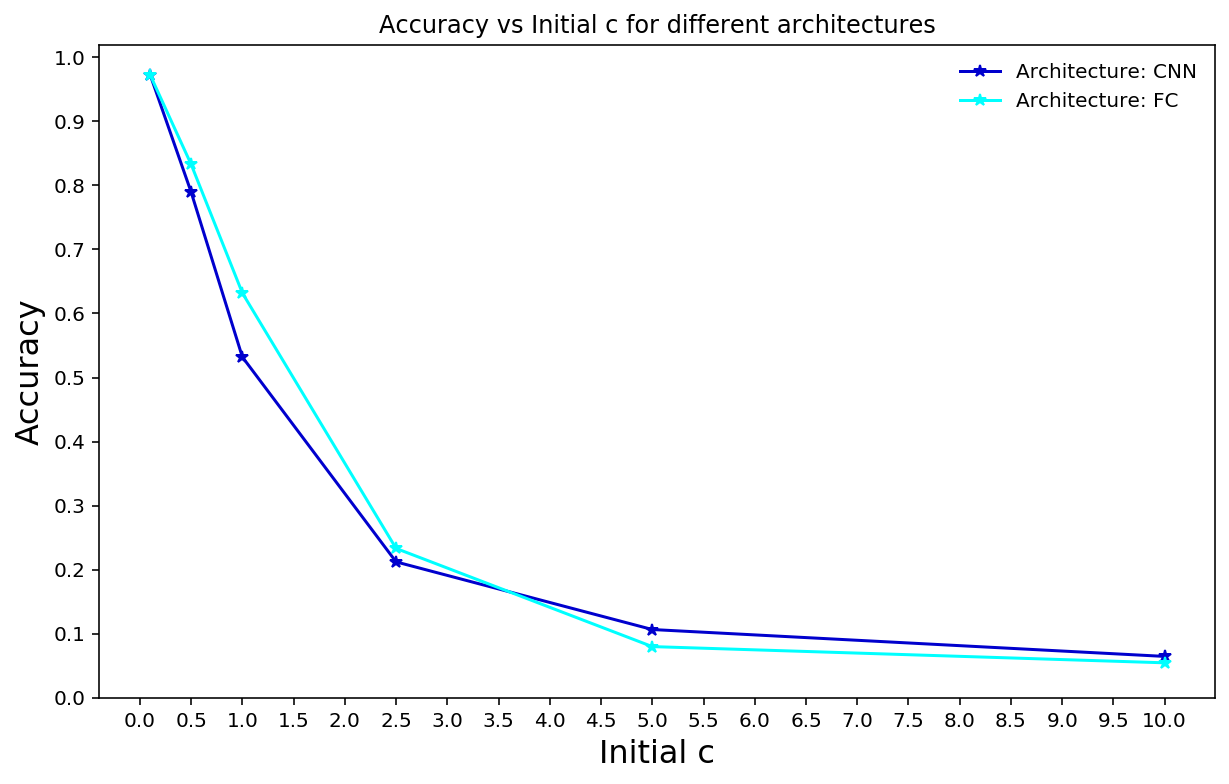

In [78]:
# plot the accuracies vs constant c

plt.figure(figsize=(10,6))
colors =  ['mediumblue', 'aqua']

for idx, (arch, results) in enumerate(accs.items()):
    plt.plot(constants, results, "*-", color=colors[idx], label="Architecture: {}".format(arch))

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 10.1, step=0.5))
plt.title("Accuracy vs Initial c for different architectures")
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

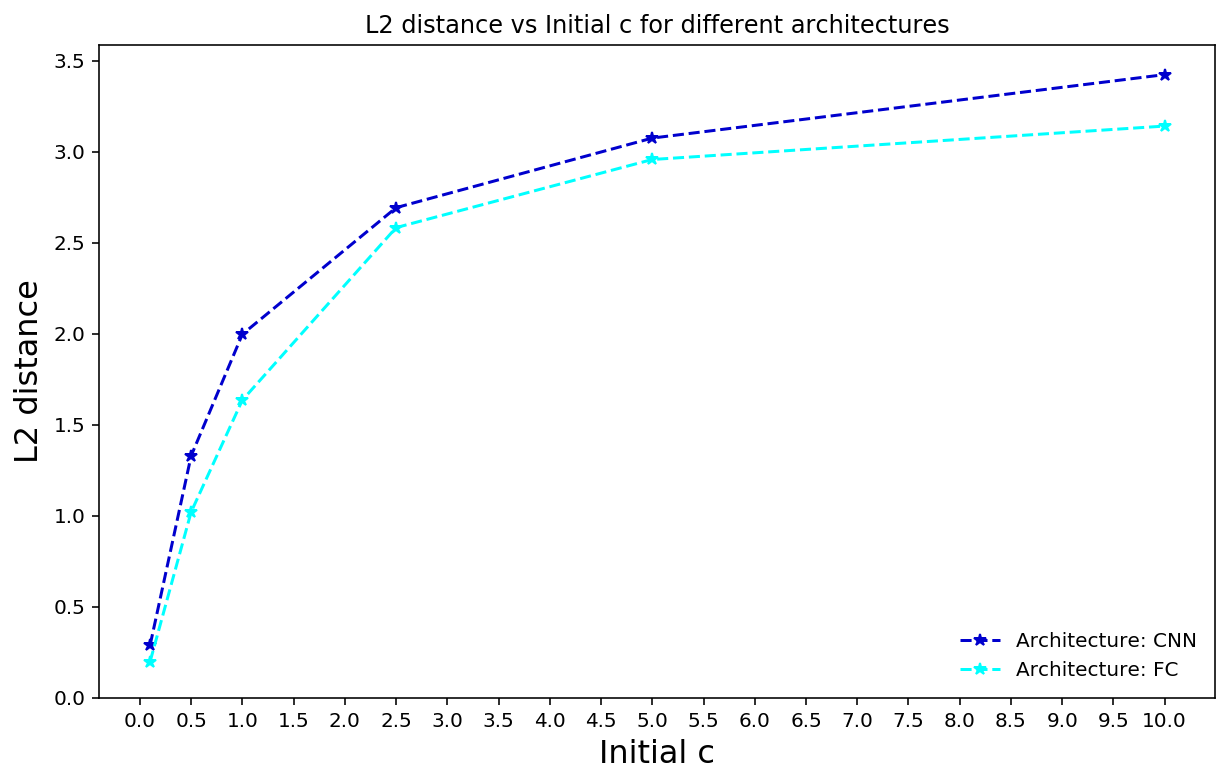

In [79]:
# plot the distances vs constant c

plt.figure(figsize=(10,6))
colors =  ['mediumblue', 'aqua']

for idx, (arch, results) in enumerate(dists.items()):
    plt.plot(constants, results, "*--", color=colors[idx], label="Architecture: {}".format(arch))

plt.yticks(np.arange(0, 3.6, step=0.5))
plt.xticks(np.arange(0, 10.5, step=0.5))
plt.title("L2 distance vs Initial c for different architectures")
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("L2 distance",fontsize=16)
plt.legend(loc='lower right', frameon=False)
plt.show()

### LInf

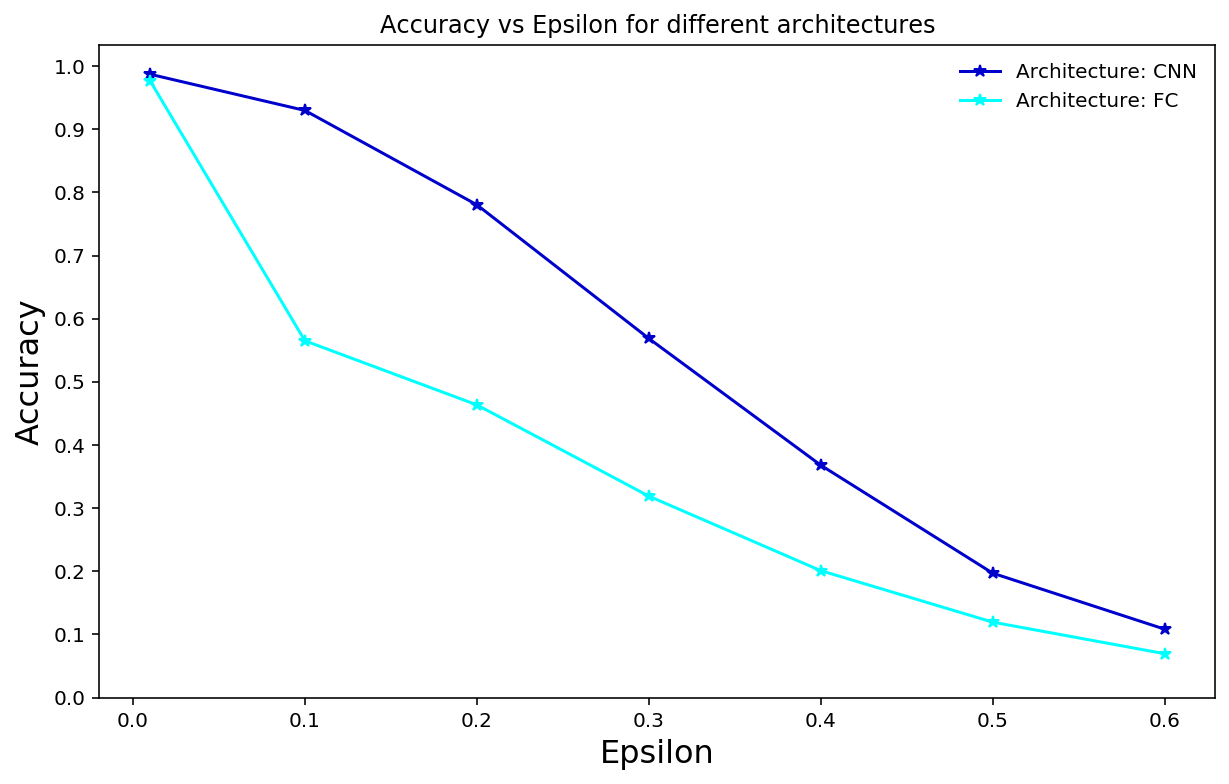

In [96]:
# plot the pruned accuracies vs epsilon

plt.figure(figsize=(10,6))
colors =  ['mediumblue', 'aqua']

for idx, (arch, results) in enumerate(acc.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label="Architecture: {}".format(arch))

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.61, step=0.1))
plt.title("Accuracy vs Epsilon for different architectures")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()